In [10]:
from jax import config
config.update('jax_enable_x64', True)
from pathlib import Path

import jax
import jax.numpy as jnp
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns

from numpyro.distributions import MultivariateNormal
from uncprop.core.distribution import GaussianFromNumpyro

from uncprop.models.vsem.experiment import summarize_rep, load_results
from uncprop.utils.plot import set_plot_theme, smart_subplots
from uncprop.utils.grid import plot_coverage_curve_reps

colors = set_plot_theme()
base_dir = Path('/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper')

from pde_model import (
    get_discrete_source, 
    solve_pde, 
    solve_pde_vmap,
)

In [2]:
key = jr.key(12412)

In [3]:
# grid 
n_grid = 100
xgrid = jnp.linspace(0.0, 1.0, n_grid)

# diffusivity
key_diffusivity, key = jr.split(key, 2)
diffusivity = jnp.abs(0.1 + 0.05 * jr.normal(key_diffusivity, (n_grid,)))

# boundary conditions
left_flux = -1.0
rightbc = 1.0

# source term
source_wells = jnp.array([0.2, 0.4, 0.6, 0.8])
source_strength = 0.8
source_width = 0.05
source = get_discrete_source(xgrid, well_locations=source_wells, 
                             strength=source_strength, width=source_width)

In [4]:
u = solve_pde(xgrid=xgrid, 
              left_flux=left_flux, 
              k=diffusivity, 
              source=source, 
              rightbc=rightbc)

### Prior

In [11]:
from gpjax.kernels.stationary import PoweredExponential

prior_kernel = PoweredExponential(lengthscale=0.3, variance=1.0, power=0.3, n_dims=1)
prior_mean = jnp.tile(1.0, n_grid)
prior_cov = prior_kernel.gram(xgrid.reshape((-1,1))).to_dense()
prior =GaussianFromNumpyro(MultivariateNormal(prior_mean, prior_cov))

In [14]:
def plot_marginals(key, dist, grid, colors, alpha=0.3, n_samp=0):

    fig, ax = plt.subplots()

    # intervals
    sd = jnp.sqrt(jnp.diag(dist.cov))
    lower = dist.mean - 2 * sd
    upper = dist.mean + 2 * sd

    ax.fill_between(grid, lower, upper, alpha=alpha, label='+/- 2 sd')
    ax.plot(grid, dist.mean, color='black', label='mean')

    if n_samp > 0:
        samp = dist.sample(key, n_samp)
        ax.plot(grid, samp.T)
    ax.legend()

    return fig, ax

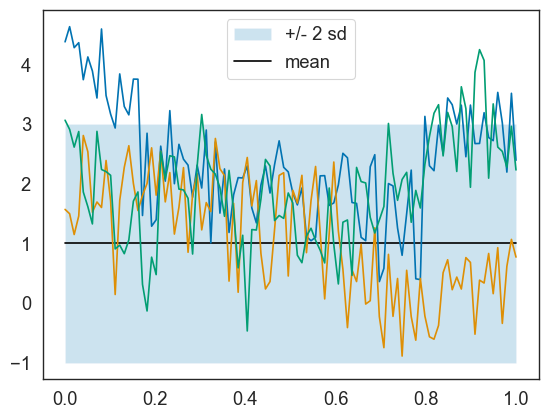

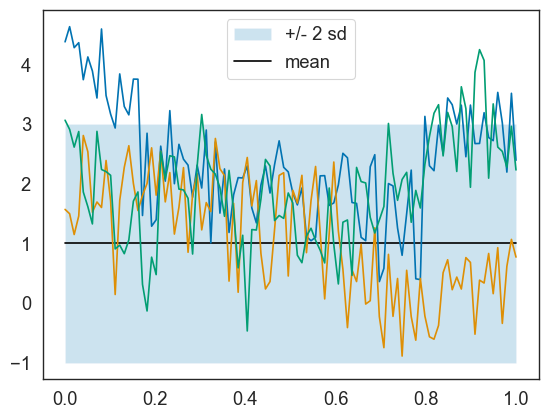

In [15]:
key_plot, key = jr.split(key)

fig_prior, ax_prior = plot_marginals(key, prior, xgrid, colors, alpha=0.2, n_samp=3)

display(fig_prior)